# LinkML-Map tutorial

This tutorial walks through basic programmatic use of the LinkML-Map framework.
This is intended for Python developers - note that many of the operations here can also be performed
at the command line.

In [1]:
import yaml

## Creating an example schema

We will use a LinkML SchemaBuilder object to progressively build up a schema, adding
additional features as we go.

We'll start with a simple `Person` schema, with a few single valued scalar slots:

In [2]:
from linkml.utils.schema_builder import SchemaBuilder
from linkml_runtime.linkml_model import SlotDefinition

sb = SchemaBuilder()
sb.add_class("Person", slots=[SlotDefinition("family_name", range="string"), 
                              SlotDefinition("given_name", range="string"),
                              SlotDefinition("age_in_years", range="integer"),
                              SlotDefinition("height_in_cm", range="float"),
                              ])
sb.add_defaults()
print(yaml.dump(sb.as_dict(), sort_keys=False))

name: test-schema
id: http://example.org/test-schema
imports:
- linkml:types
prefixes:
  linkml: https://w3id.org/linkml/
  test_schema: http://example.org/test-schema/
default_prefix: test_schema
default_range: string
slots:
  family_name:
    range: string
  given_name:
    range: string
  age_in_years:
    range: integer
  height_in_cm:
    range: float
classes:
  Person:
    slots:
    - family_name
    - given_name
    - age_in_years
    - height_in_cm


## Creating a Transformer Session object

We will use a `Session` object which conveniently wraps a number of different capabilities;
the first of these capabilities is to map (transform) data objects from one schema to another
(implicit) schema using a *transformer specification*).

Our initial transformer specification will be a trivial isomorphic one that:

- maps the `Person` class to an `Individual` class
- passes through `name` fields as-is
- renames measurement fields (`age_in_years` and `height_in_cm` to `age` and `height`)

In [3]:
from linkml_map.session import Session

session = Session()
session.set_source_schema(sb.as_dict())

In [4]:
# Transformer specification (in YAML)
session.set_object_transformer("""
class_derivations:
  Individual:
    populated_from: Person
    slot_derivations:
      family_name:
        populated_from: family_name
      given_name:
        populated_from: given_name
      age:
        populated_from: age_in_years
      height:
        populated_from: height_in_cm
""")

## Visualizing transformer specifications

We can visualize the transformer specification using graphviz:

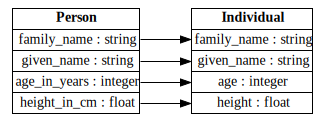

In [5]:
session.graphviz()

## Transforming objects

We'll next make a simple `Person` object. Note that for simplicity we are specifying this
using a Python dictionary. The framework also works with objects instantiating either
Pydantic or Dataclasses classes (use the `transform_object` method instead of `transform`).

In [6]:
obj = {
        "given_name": "Jane",
        "family_name": "Doe",
        "age_in_years": 42,
        "height_in_cm": 180.0,
    }
session.transform(obj)

{'family_name': 'Doe', 'given_name': 'Jane', 'age': 42, 'height': 180.0}

This does what we expect - it renames the two fields, but leaves all values intact.

Note that because we use using dictionaries here, the renaming of the class has no effect,
as this is implicit with JSON/dictionaries.

TODO: docs on type designator fields

For command line users, the same thing can be achieved with the `map-data` command.

## Deriving target schemas

LinkML-Transformer is intended as a *declarative* framework, in contrast to writing Python
transformation code. This allows tools to introspect mappings and perform other kinds of inference.
An example of this is *deriving the (implicit) target schema*

Here we use the `target_schema` method on the session object to derive the target schema:

In [7]:
from linkml_runtime.dumpers import yaml_dumper

print(yaml_dumper.dumps(session.target_schema))

name: test-schema-derived
id: http://example.org/test-schema-derived
imports:
- linkml:types
prefixes:
  linkml:
    prefix_prefix: linkml
    prefix_reference: https://w3id.org/linkml/
  test_schema:
    prefix_prefix: test_schema
    prefix_reference: http://example.org/test-schema/
default_prefix: http://example.org/test-schema-derived/
default_range: string
classes:
  Individual:
    name: Individual
    attributes:
      family_name:
        name: family_name
        domain_of:
        - Person
        range: string
      given_name:
        name: given_name
        domain_of:
        - Person
        range: string
      age:
        name: age
        domain_of:
        - Person
        range: integer
      height:
        name: height
        domain_of:
        - Person
        range: float


As expected, this is isomorphic to the original (source) schema, with fields and classes renamed.

## Using Expressions

In addition to renaming fields, we can derive field values via evaluation of function *expressions*.

You are encouraged to follow the subset of Python defined by the LinkML expression language. This provides
both safety, and declarativity. However, if you need
to, you can include arbitrary Python code, provided you configure the session to allow this.

We'll keep the original schema, and will provide a new Transformer specification, 
giving an example of both string manipulation functions and arithmetic functions; the latter
perform unit conversions (later on we will see more flexible and declarative ways to perform unit conversions).



In [8]:

session.set_object_transformer("""
class_derivations:
  Individual:
    populated_from: Person
    slot_derivations:
      name:
        expr: "{given_name} + ' ' + {family_name}"
        description: Concatenating given and family names
          note this is a bad assumption for names in general,
          this is just for demonstration
      age_in_months:
        expr: age_in_years * 12
      height_in_meters:
        expr: height_in_cm / 100
""")


Note that when we visualize this specification, dotted lines are shown indicating a relationship
between source and target that is different from direct copy:

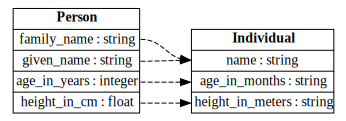

In [9]:
session.graphviz()

Now we'll transform the same object as before, and see the results:

In [10]:
session.transform(obj)

{'name': 'Jane Doe', 'age_in_months': 504, 'height_in_meters': 1.8}

As expected, we concatenated the name fields, and converted the age and height fields to different units.

Let's take a look at the derived schema for this new transformation:

In [11]:
print(yaml_dumper.dumps(session.target_schema))

name: test-schema-derived
id: http://example.org/test-schema-derived
imports:
- linkml:types
prefixes:
  linkml:
    prefix_prefix: linkml
    prefix_reference: https://w3id.org/linkml/
  test_schema:
    prefix_prefix: test_schema
    prefix_reference: http://example.org/test-schema/
default_prefix: http://example.org/test-schema-derived/
default_range: string
classes:
  Individual:
    name: Individual
    attributes:
      name:
        name: name
      age_in_months:
        name: age_in_months
      height_in_meters:
        name: height_in_meters


Note that at this time, deriving ranges using expressions is not supported, so the two measurement fields
are erroneously typed as having the `default_range` of `string`. However, in principle, if you use the
linkml subset of Python it should be possible to infer the range of the derived field, and this may be added
in future versions. Currently the tool chain is at an early stage of development.

## Unit conversions

Next we will look at a different way of doing unit conversions. The LinkML specification allows
schemas to explicitly declare the units of slots, so let's modify our schema to do this, adding
a UCUM code for our `height_in_cm` slot:

In [12]:
from linkml_runtime.linkml_model.units import UnitOfMeasure
sb.schema.slots['height_in_cm'].unit = UnitOfMeasure(ucum_code='cm')
session.set_source_schema(sb.as_dict())
print(yaml.dump(sb.as_dict(), sort_keys=False))

name: test-schema
id: http://example.org/test-schema
imports:
- linkml:types
prefixes:
  linkml: https://w3id.org/linkml/
  test_schema: http://example.org/test-schema/
default_prefix: test_schema
default_range: string
slots:
  family_name:
    range: string
  given_name:
    range: string
  age_in_years:
    range: integer
  height_in_cm:
    range: float
    unit:
      ucum_code: cm
classes:
  Person:
    slots:
    - family_name
    - given_name
    - age_in_years
    - height_in_cm


## Adding target_unit to transformer specification

We will create a new transformer specification, focusing on the `height_in_cm` field. We will
transform this into a `height_in_meters` field, and will use the `target_unit` field to specify
the target unit.

In [13]:
session.set_object_transformer("""
class_derivations:
  Individual:
    populated_from: Person
    slot_derivations:
      name:
        expr: "{given_name} + ' ' + {family_name}"
      height_in_meters:
        populated_from: height_in_cm
        unit_conversion:
          target_unit: m
""")

In [14]:
session.transform(obj)

{'name': 'Jane Doe', 'height_in_meters': 1.8}

## Units in derived schema

Next we'll look at the derived target schema, and as expected we see that it has inferred
the target unit for the `height_in_meters` field:

In [15]:
print(yaml_dumper.dumps(session.target_schema))


name: test-schema-derived
id: http://example.org/test-schema-derived
imports:
- linkml:types
prefixes:
  linkml:
    prefix_prefix: linkml
    prefix_reference: https://w3id.org/linkml/
  test_schema:
    prefix_prefix: test_schema
    prefix_reference: http://example.org/test-schema/
default_prefix: http://example.org/test-schema-derived/
default_range: string
classes:
  Individual:
    name: Individual
    attributes:
      name:
        name: name
      height_in_meters:
        name: height_in_meters
        domain_of:
        - Person
        range: float
        unit:
          ucum_code: m


## Tabular serialization

In [16]:
slot = sb.add_slot("aliases", multivalued=True, range="string", replace_if_present=True)

In [17]:
sb.schema.classes['Person'].slots.append(slot.name)

In [18]:
session.set_source_schema(sb.as_dict())

In [19]:
session.set_object_transformer("""
class_derivations:
  Individual:
    populated_from: Person
    slot_derivations:
      family_name:
        populated_from: family_name
      given_name:
        populated_from: given_name
      age:
        populated_from: age_in_years
      height:
        populated_from: height_in_cm
      aliases:
        populated_from: aliases
        stringification:
          delimiter: '|'
""")    

In [20]:
obj = {
        "given_name": "Jane",
        "family_name": "Doe",
        "age_in_years": 42,
        "height_in_cm": 180.0,
        "aliases": ["Jane", "Janie", "Janey"]
    }
flattened = session.transform(obj)
flattened

{'family_name': 'Doe',
 'given_name': 'Jane',
 'age': 42,
 'height': 180.0,
 'aliases': 'Jane|Janie|Janey'}

this can easily be serialized to a CSV/TSV

## Reverse transform

If a transform does not contain one-way functions,
it can be *reversed*.

In this case, reversing the transform allows us to map
from the tabular form back to the richer original representation.

In [21]:
session.reverse_transform(flattened)

{'family_name': 'Doe',
 'given_name': 'Jane',
 'age_in_years': 42,
 'height_in_cm': 180.0,
 'aliases': ['Jane', 'Janie', 'Janey']}